In [1]:
from pathlib import Path
import torch
import pandas as pd
import stat
import numbers
import pydicom
import numpy as np
from tqdm import tqdm
from collections import Counter
import re
import os
from PIL import Image
from matplotlib import pyplot as plt
from plotnine import *
from pydicom_PIL import get_PIL_image

In [2]:
Path().resolve()

PosixPath('/home/buehlern/Documents/Masterarbeit/notebooks')

In [3]:
df_loc = Path('cache/prep_df.pkl')
df = pd.read_pickle(df_loc)

In [4]:
len(df)

647633

In [ ]:
pydicom.read_file(df['path'][3])

In [ ]:
df[df['findings'] != ""]['findings'][:50]

In [ ]:
print(df['findings'][300])

# Masking

In [6]:
def create_patches(img, patch_size):
    patches = []
    for i in range(0, img.shape[0], patch_size):
        for j in range(0, img.shape[1], patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

In [7]:
def mask_patches(patches, mask_ratio):
    num_patches = len(patches)
    num_masked = int(num_patches * mask_ratio)
    masked_indices = np.random.choice(num_patches, num_masked, replace=False)
    masked_patches = patches.copy()
    for idx in masked_indices:
        masked_patches[idx] = np.zeros_like(patches[idx])
    return masked_patches

In [8]:
def plot_masked_image(idx, patch_size, mask_ratio):
    image = pydicom.read_file(df['path'][idx]).pixel_array
    patient_id = df['patientid'][idx]
    
    masked_image = image.copy()
    h, w = image.shape
    
    patches = create_patches(image, patch_size)
    masked_patches = mask_patches(patches, mask_ratio)
    
    patch_idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            if i + patch_size <= h and j + patch_size <= w:
                masked_image[i:i+patch_size, j:j+patch_size] = masked_patches[patch_idx]
                patch_idx += 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(masked_image, cmap='gray')
    axes[1].set_title('Masked image (ps=' + str(patch_size) + ', mr=' + str(mask_ratio) + ')')
    axes[1].axis('off')
    
    plt.savefig(patient_id + '_masked_' + str(patch_size) + '_' + str(mask_ratio) + '.png')
    
    plt.show()

In [9]:
def inspect_item(idx, patch_size=32, mask_ratio=0.5):
    print(df['findings'][idx])
    plot_masked_image(idx, patch_size, mask_ratio)

In [ ]:
inspect_item(300, patch_size=64, mask_ratio=0.3)

# Follow up Scans

In [ ]:
df['patientid'][:10]

In [ ]:
pid = df['patientid'][4]
df[df['patientid'] == pid]

In [13]:
all_patient_ids = df['patientid'].unique()
len(all_patient_ids)

131501

In [ ]:
pd.options.display.max_columns = None
df[:1]

In [15]:
def inspect_patient(idx):
    patient_id = df['patientid'].unique()[idx]
    items = df[df['patientid'] == patient_id]
    paths = items['path']
    examination_ids = items['examinationid']
    dates = items['dcm_StudyDate']

    fig, axes = plt.subplots(1, len(paths), figsize=(6*len(paths), 6))

    if len(paths) > 1:
        for i, item in enumerate(zip(paths, examination_ids, dates)):
            p, ex_id, date = item
            image = pydicom.read_file(p).pixel_array
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title('Examination ' + ex_id + ' ('+date+')')
            axes[i].axis('off')
    else:
        image = pydicom.read_file(paths[0]).pixel_array
        ex_id = examination_ids[0]
        plt.imshow(image, cmap='gray')
        plt.title('Examination ' + ex_id)
        plt.axis('off')
    
    plt.savefig(str(patient_id) + '_series.png')
    plt.show()

In [ ]:
inspect_patient(4)

In [ ]:
watchdog = 20
for i, pid in enumerate(all_patient_ids):
    items = df[df['patientid'] == pid]
    count = len(items['examinationid'].unique())
    if count > 1:
        print(i, pid, count)
        watchdog -= 1
    if watchdog == 0:
        break

In [ ]:
inspect_patient(29)

# Pixel Spacing

In [19]:
df[['dcm_SpatialResolution', 'dcm_ImagerPixelSpacing']].describe()

,dcm_SpatialResolution
count,325217.000000
mean,0.143923
std,0.000893
min,0.143000
25%,0.144000
50%,0.144000
75%,0.144000
max,0.148000


# Invalid scans

In [20]:
pixelarr_cols = [col for col in df.columns if "pixelarr" in col]
pixelarr_cols

['pixelarr_dtype',
 'pixelarr_shape',
 'pixelarr_non0count',
 'pixelarr_min',
 'pixelarr_max',
 'pixelarr_mean',
 'pixelarr_std',
 'pixelarr_non0min',
 'pixelarr_non0mean',
 'pixelarr_non0std']

In [21]:
df[pixelarr_cols].describe()

,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
count,6.476330e+05,647633.000000,647633.000000,647633.000000,647633.000000,647628.000000,647628.000000,647628.000000
mean,2.683850e+06,6.671467,17844.644246,6978.042800,4852.668125,504.869087,7959.579443,4481.248335
std,1.676600e+06,53.293447,14202.675007,5562.060235,3899.247734,998.293538,6085.522938,3709.491718
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,98.441870,105.600204
25%,1.536783e+06,0.000000,4095.000000,1691.436289,1147.740894,1.000000,2198.943540,1017.834149
50%,2.254891e+06,0.000000,4095.000000,3483.556639,1466.429898,16.000000,3485.710602,1446.267311
75%,3.484459e+06,0.000000,32767.000000,12227.392778,8788.724406,709.000000,13909.376860,8134.014985
max,2.952781e+07,5160.000000,32767.000000,27829.995605,14044.131912,15140.000000,28476.738595,13295.050230


/home/buehlern/Documents/Masterarbeit/venv/lib/python3.8/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 15 rows containing non-finite values.


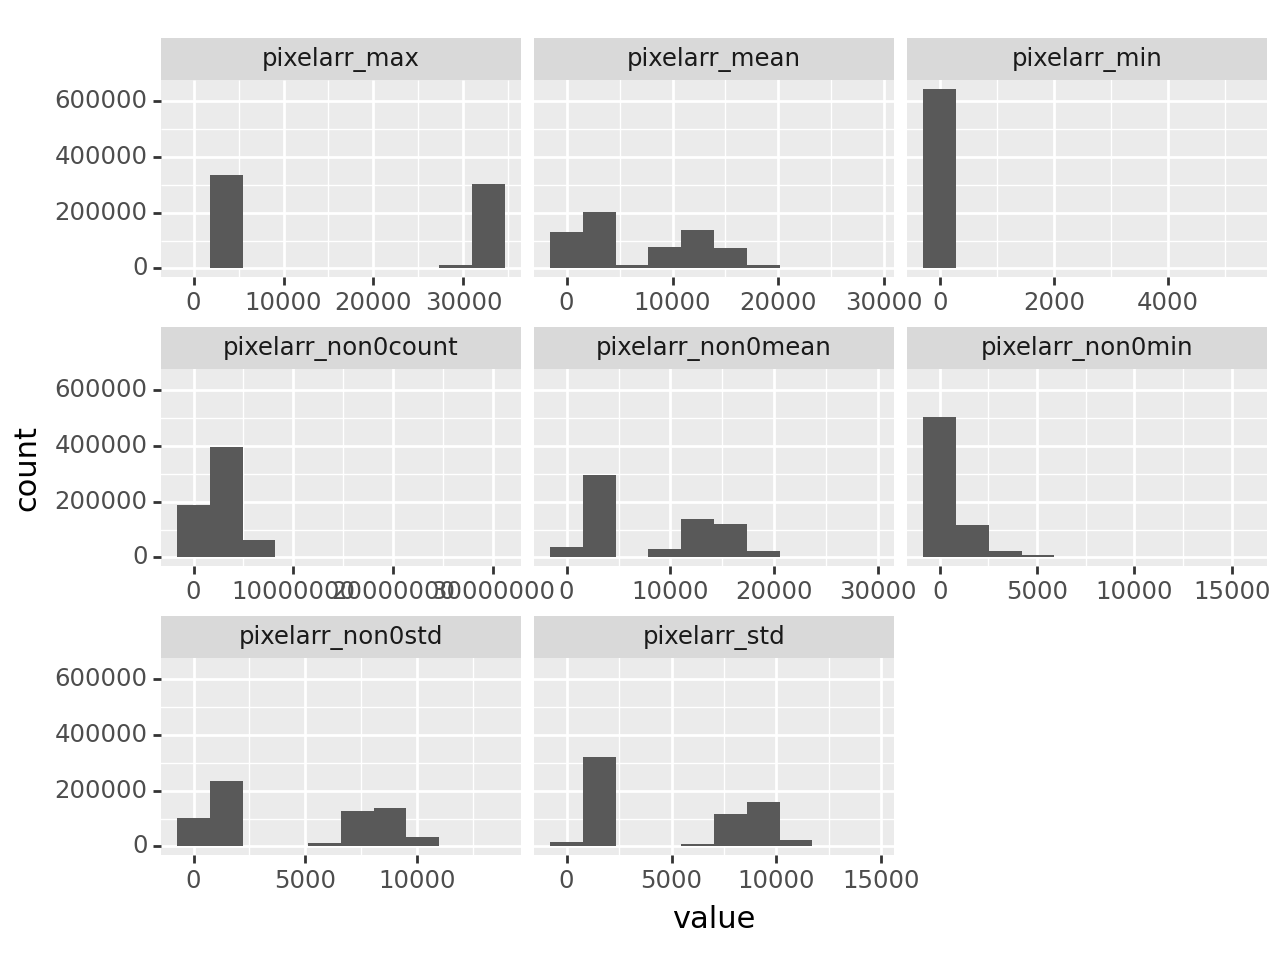

<Figure Size: (640 x 480)>

In [17]:
cols = ['pixelarr_non0count',
         'pixelarr_min',
         'pixelarr_max',
         'pixelarr_mean',
         'pixelarr_std',
         'pixelarr_non0min',
         'pixelarr_non0mean',
         'pixelarr_non0std']
plot_data = pd.melt(df, value_vars=cols, var_name="variable", value_name="value")
p = (ggplot(plot_data, aes(x="value")) + geom_histogram(bins=10) + facet_wrap("~variable", scales="free_x"))
p

## pixelarr_max

In [22]:
df.loc[df['pixelarr_max'] == 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


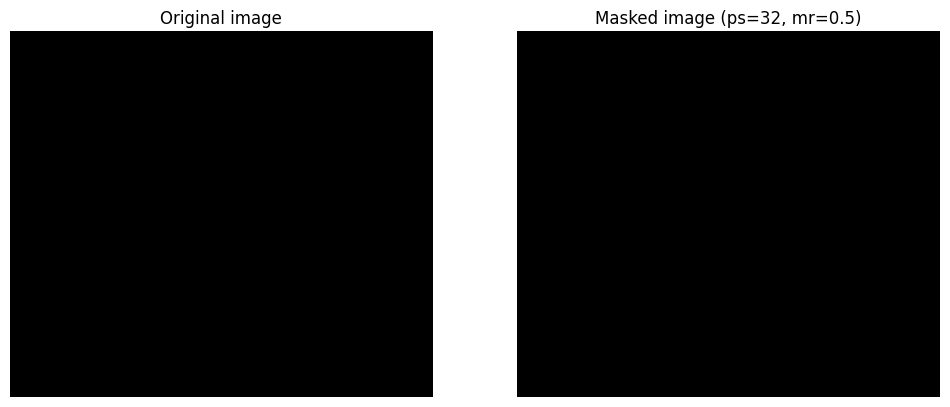

In [23]:
inspect_item(387615)

In [24]:
df.loc[df['pixelarr_max'] <= 1000][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
145715,uint16,"(1024, 1024)",33856.0,0.0,960.0,24.915161,145.771307,128.0,771.663516,286.158165
341996,uint16,"(1024, 1024)",34252.0,0.0,960.0,25.274292,146.881806,128.0,773.736307,285.224528
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN


In [ ]:
inspect_item(145715)

In [25]:
drop_idx = df.loc[df['pixelarr_max'] <= 1000].index
drop_idx

Index([145715, 341996, 387615, 387617, 419003, 474820, 517437], dtype='int64')

In [26]:
df_clean = df.drop(drop_idx)

In [27]:
df_clean.loc[df['pixelarr_max'] <= 1000]

,patientid,bodypart,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,dcm_SpecificCharacterSet,dcm_ImageType,dcm_InstanceCreationDate,dcm_InstanceCreationTime,dcm_InstanceCreatorUID,dcm_SOPClassUID,dcm_SOPInstanceUID,dcm_StudyDate,dcm_SeriesDate,dcm_AcquisitionDate,dcm_ContentDate,dcm_StudyTime,dcm_SeriesTime,dcm_AcquisitionTime,dcm_ContentTime,dcm_DataSetSubtype,dcm_AccessionNumber,dcm_Modality,dcm_ModalitiesInStudy,dcm_ConversionType,dcm_PresentationIntentType,dcm_Manufacturer,dcm_ReferringPhysicianName,dcm_CodeValue,dcm_CodingSchemeDesignator,dcm_CodeMeaning,dcm_ProcedureCodeSequence,dcm_SeriesDescription,dcm_ManufacturerModelName,dcm_ReferencedSeriesSequence,dcm_RecommendedDisplayFrameRate,dcm_AnatomicRegionSequence,dcm_IrradiationEventUID,dcm_FrameType,dcm_PatientName,dcm_PatientID,dcm_PatientBirthDate,dcm_PatientSex,dcm_PatientAge,dcm_PatientSize,dcm_PatientWeight,dcm_EthnicGroup,dcm_PregnancyStatus,dcm_PatientIdentityRemoved,dcm_DeidentificationMethod,dcm_DeidentificationMethodCodeSequence,dcm_ContrastBolusAgent,dcm_BodyPartExamined,dcm_ScanningSequence,dcm_SequenceVariant,dcm_ScanOptions,dcm_MRAcquisitionType,dcm_SequenceName,dcm_AngioFlag,dcm_CineRate,dcm_SliceThickness,dcm_KVP,dcm_RepetitionTime,dcm_EchoTime,dcm_InversionTime,dcm_NumberOfAverages,dcm_ImagingFrequency,dcm_ImagedNucleus,dcm_EchoNumbers,dcm_MagneticFieldStrength,dcm_SpacingBetweenSlices,dcm_NumberOfPhaseEncodingSteps,dcm_DataCollectionDiameter,dcm_EchoTrainLength,dcm_PercentSampling,dcm_PercentPhaseFieldOfView,dcm_PixelBandwidth,dcm_DeviceSerialNumber,dcm_PlateID,dcm_SecondaryCaptureDeviceID,dcm_DateOfSecondaryCapture,dcm_TimeOfSecondaryCapture,dcm_SecondaryCaptureDeviceManufacturer,dcm_SecondaryCaptureDeviceManufacturerModelName,dcm_SecondaryCaptureDeviceSoftwareVersions,dcm_SoftwareVersions,dcm_ProtocolName,dcm_ContrastBolusRoute,dcm_ContrastBolusVolume,dcm_ContrastBolusTotalDose,dcm_ContrastFlowRate,dcm_ContrastBolusIngredientConcentration,dcm_SpatialResolution,dcm_FrameTime,dcm_FrameDelay,dcm_LowRRValue,dcm_HighRRValue,dcm_IntervalsAcquired,dcm_IntervalsRejected,dcm_HeartRate,dcm_ReconstructionDiameter,dcm_DistanceSourceToDetector,dcm_DistanceSourceToPatient,dcm_EstimatedRadiographicMagnificationFactor,dcm_GantryDetectorTilt,dcm_TableHeight,dcm_TableMotion,dcm_TableAngle,dcm_TableType,dcm_RotationDirection,dcm_AngularPosition,dcm_ScanArc,dcm_FieldOfViewShape,dcm_FieldOfViewDimensions,dcm_ExposureTime,dcm_XRayTubeCurrent,dcm_Exposure,dcm_ExposureInuAs,dcm_AveragePulseWidth,dcm_RadiationSetting,dcm_RectificationType,dcm_RadiationMode,dcm_ImageAndFluoroscopyAreaDoseProduct,dcm_FilterType,dcm_TypeOfFilters,dcm_ImagerPixelSpacing,dcm_Grid,dcm_GeneratorPower,dcm_CollimatorGridName,dcm_FocalSpots,dcm_AnodeTargetMaterial,dcm_BodyPartThickness,dcm_CompressionForce,dcm_PaddleDescription,dcm_DateOfLastCalibration,dcm_TimeOfLastCalibration,dcm_ConvolutionKernel,dcm_PreferredPlaybackSequencing,dcm_ReceiveCoilName,dcm_TransmitCoilName,dcm_PlateType,dcm_AcquisitionMatrix,dcm_InPlanePhaseEncodingDirection,dcm_FlipAngle,dcm_VariableFlipAngleFlag,dcm_SAR,dcm_dBdt,dcm_AcquisitionDeviceProcessingDescription,dcm_AcquisitionDeviceProcessingCode,dcm_CassetteOrientation,dcm_CassetteSize,dcm_ExposuresOnPlate,dcm_RelativeXRayExposure,dcm_ExposureIndex,dcm_TargetExposureIndex,dcm_DeviationIndex,dcm_PositionerMotion,dcm_PositionerType,dcm_PositionerPrimaryAngle,dcm_PositionerSecondaryAngle,dcm_DetectorSecondaryAngle,dcm_ShutterShape,dcm_ShutterLeftVerticalEdge,dcm_ShutterRightVerticalEdge,dcm_ShutterUpperHorizontalEdge,dcm_ShutterLowerHorizontalEdge,dcm_CenterOfCircularShutter,dcm_RadiusOfCircularShutter,dcm_VerticesOfThePolygonalShutter,dcm_ShutterPresentationValue,dcm_CollimatorShape,dcm_CollimatorLeftVerticalEdge,dcm_CollimatorRightVerticalEdge,dcm_CollimatorUpperHorizontalEdge,dcm_CollimatorLowerHorizontalEdge,dcm_CenterOfCircularCollimator,dcm_RadiusOfCircularCollimator,dcm_VerticesOfThePolygonalCollimator,dcm_ProcessingFunction,dcm_PostprocessingFunction,dcm_PatientPositi

## pixelarr_mean

In [28]:
df.loc[df['pixelarr_mean'] == 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [29]:
df.loc[df['pixelarr_mean'] <= 100][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
49975,uint16,"(3000, 3000)",298468.0,0.0,4095.0,73.270322,423.633643,5.0,2209.392277,831.906125
55415,uint16,"(3000, 3000)",670420.0,0.0,4095.0,86.438889,433.616330,2.0,1160.391995,1130.440120
55416,uint16,"(3000, 3000)",488604.0,0.0,4095.0,64.931973,407.634970,1.0,1196.035548,1306.871627
57665,uint16,"(3000, 3000)",363547.0,0.0,4095.0,70.297482,391.947025,5.0,1740.290353,947.004894
57666,uint16,"(3000, 3000)",363547.0,0.0,4095.0,70.297482,391.947025,5.0,1740.290353,947.004894
83309,uint16,"(3893, 3681)",485374.0,0.0,4094.0,87.686980,491.446745,698.0,2588.861538,809.576822
145715,uint16,"(1024, 1024)",33856.0,0.0,960.0,24.915161,145.771307,128.0,771.663516,286.158165
233911,uint16,"(3000, 3000)",9000000.0,5.0,4095.0,98.441870,534.768263,5.0,98.441870,534.768263
341996,uint16,"(1024, 1024)",34252.0,0.0,960.0,25.274292,146.881806,128.0,773.736307,285.224528
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN


In [30]:
len(df.loc[df['pixelarr_mean'] <= 100])

36

In [ ]:
inspect_item(49975)

In [31]:
drop_idx = df_clean.loc[df_clean['pixelarr_mean'] <= 100].index
drop_idx

Index([ 49975,  55415,  55416,  57665,  57666,  83309, 233911, 456395, 485573,
       488053, 488075, 580466, 580467, 600990, 615922, 617907, 626632, 626634,
       630912, 631778, 631779, 648113, 696809, 696811, 696815, 701178, 704483,
       706564, 715025],
      dtype='int64')

In [32]:
df_clean = df_clean.drop(drop_idx)

In [33]:
df_clean.loc[df['pixelarr_mean'] <= 100]

,patientid,bodypart,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,dcm_SpecificCharacterSet,dcm_ImageType,dcm_InstanceCreationDate,dcm_InstanceCreationTime,dcm_InstanceCreatorUID,dcm_SOPClassUID,dcm_SOPInstanceUID,dcm_StudyDate,dcm_SeriesDate,dcm_AcquisitionDate,dcm_ContentDate,dcm_StudyTime,dcm_SeriesTime,dcm_AcquisitionTime,dcm_ContentTime,dcm_DataSetSubtype,dcm_AccessionNumber,dcm_Modality,dcm_ModalitiesInStudy,dcm_ConversionType,dcm_PresentationIntentType,dcm_Manufacturer,dcm_ReferringPhysicianName,dcm_CodeValue,dcm_CodingSchemeDesignator,dcm_CodeMeaning,dcm_ProcedureCodeSequence,dcm_SeriesDescription,dcm_ManufacturerModelName,dcm_ReferencedSeriesSequence,dcm_RecommendedDisplayFrameRate,dcm_AnatomicRegionSequence,dcm_IrradiationEventUID,dcm_FrameType,dcm_PatientName,dcm_PatientID,dcm_PatientBirthDate,dcm_PatientSex,dcm_PatientAge,dcm_PatientSize,dcm_PatientWeight,dcm_EthnicGroup,dcm_PregnancyStatus,dcm_PatientIdentityRemoved,dcm_DeidentificationMethod,dcm_DeidentificationMethodCodeSequence,dcm_ContrastBolusAgent,dcm_BodyPartExamined,dcm_ScanningSequence,dcm_SequenceVariant,dcm_ScanOptions,dcm_MRAcquisitionType,dcm_SequenceName,dcm_AngioFlag,dcm_CineRate,dcm_SliceThickness,dcm_KVP,dcm_RepetitionTime,dcm_EchoTime,dcm_InversionTime,dcm_NumberOfAverages,dcm_ImagingFrequency,dcm_ImagedNucleus,dcm_EchoNumbers,dcm_MagneticFieldStrength,dcm_SpacingBetweenSlices,dcm_NumberOfPhaseEncodingSteps,dcm_DataCollectionDiameter,dcm_EchoTrainLength,dcm_PercentSampling,dcm_PercentPhaseFieldOfView,dcm_PixelBandwidth,dcm_DeviceSerialNumber,dcm_PlateID,dcm_SecondaryCaptureDeviceID,dcm_DateOfSecondaryCapture,dcm_TimeOfSecondaryCapture,dcm_SecondaryCaptureDeviceManufacturer,dcm_SecondaryCaptureDeviceManufacturerModelName,dcm_SecondaryCaptureDeviceSoftwareVersions,dcm_SoftwareVersions,dcm_ProtocolName,dcm_ContrastBolusRoute,dcm_ContrastBolusVolume,dcm_ContrastBolusTotalDose,dcm_ContrastFlowRate,dcm_ContrastBolusIngredientConcentration,dcm_SpatialResolution,dcm_FrameTime,dcm_FrameDelay,dcm_LowRRValue,dcm_HighRRValue,dcm_IntervalsAcquired,dcm_IntervalsRejected,dcm_HeartRate,dcm_ReconstructionDiameter,dcm_DistanceSourceToDetector,dcm_DistanceSourceToPatient,dcm_EstimatedRadiographicMagnificationFactor,dcm_GantryDetectorTilt,dcm_TableHeight,dcm_TableMotion,dcm_TableAngle,dcm_TableType,dcm_RotationDirection,dcm_AngularPosition,dcm_ScanArc,dcm_FieldOfViewShape,dcm_FieldOfViewDimensions,dcm_ExposureTime,dcm_XRayTubeCurrent,dcm_Exposure,dcm_ExposureInuAs,dcm_AveragePulseWidth,dcm_RadiationSetting,dcm_RectificationType,dcm_RadiationMode,dcm_ImageAndFluoroscopyAreaDoseProduct,dcm_FilterType,dcm_TypeOfFilters,dcm_ImagerPixelSpacing,dcm_Grid,dcm_GeneratorPower,dcm_CollimatorGridName,dcm_FocalSpots,dcm_AnodeTargetMaterial,dcm_BodyPartThickness,dcm_CompressionForce,dcm_PaddleDescription,dcm_DateOfLastCalibration,dcm_TimeOfLastCalibration,dcm_ConvolutionKernel,dcm_PreferredPlaybackSequencing,dcm_ReceiveCoilName,dcm_TransmitCoilName,dcm_PlateType,dcm_AcquisitionMatrix,dcm_InPlanePhaseEncodingDirection,dcm_FlipAngle,dcm_VariableFlipAngleFlag,dcm_SAR,dcm_dBdt,dcm_AcquisitionDeviceProcessingDescription,dcm_AcquisitionDeviceProcessingCode,dcm_CassetteOrientation,dcm_CassetteSize,dcm_ExposuresOnPlate,dcm_RelativeXRayExposure,dcm_ExposureIndex,dcm_TargetExposureIndex,dcm_DeviationIndex,dcm_PositionerMotion,dcm_PositionerType,dcm_PositionerPrimaryAngle,dcm_PositionerSecondaryAngle,dcm_DetectorSecondaryAngle,dcm_ShutterShape,dcm_ShutterLeftVerticalEdge,dcm_ShutterRightVerticalEdge,dcm_ShutterUpperHorizontalEdge,dcm_ShutterLowerHorizontalEdge,dcm_CenterOfCircularShutter,dcm_RadiusOfCircularShutter,dcm_VerticesOfThePolygonalShutter,dcm_ShutterPresentationValue,dcm_CollimatorShape,dcm_CollimatorLeftVerticalEdge,dcm_CollimatorRightVerticalEdge,dcm_CollimatorUpperHorizontalEdge,dcm_CollimatorLowerHorizontalEdge,dcm_CenterOfCircularCollimator,dcm_RadiusOfCircularCollimator,dcm_VerticesOfThePolygonalCollimator,dcm_ProcessingFunction,dcm_PostprocessingFunction,dcm_PatientPositi

## pixelarr_min

In [34]:
df.loc[df['pixelarr_min'] == 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
3,uint16,"(2947, 1140)",3301521.0,0.0,32036.0,12743.812219,8946.883665,2.0,12967.918925,8862.741897
4,uint16,"(3001, 2220)",5137974.0,0.0,32767.0,12668.900806,10339.557651,1.0,16427.293000,8768.204792
5,uint16,"(2903, 1267)",3514829.0,0.0,32767.0,12603.192288,8250.258360,1.0,13188.639947,7969.150797
6,uint16,"(2622, 1132)",2875948.0,0.0,31603.0,16039.175119,8342.102678,518.0,16553.129552,7956.950748
7,uint16,"(2834, 1261)",3369923.0,0.0,31738.0,15959.056589,9168.216804,1.0,16923.966986,8532.775724
...,...,...,...,...,...,...,...,...,...,...
832160,uint16,"(3056, 1250)",3818702.0,0.0,4095.0,2536.054638,1432.957130,45.0,2536.916658,1432.437508
832162,uint16,"(1654, 960)",1286912.0,0.0,32767.0,12160.187096,9636.642909,1.0,15003.692155,8480.394116
832163,uint16,"(1485, 831)",909501.0,0.0,32767.0,13401.950745,10842.394926,1.0,18184.121059,8517.370334
832164,uint16,"(1791, 880)",1558010.0,0.0,32767.0,15787.141459,9880.353170,137.0,15970.242753,9789.250837


In [ ]:
inspect_item(3)

## pixelarr_non0count

In [35]:
df.loc[df['pixelarr_non0count'] == 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [36]:
df.loc[df['pixelarr_non0count'] <= 1000][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


## pixelarr_std

In [37]:
df.loc[df['pixelarr_std'] == 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
387615,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
387617,uint16,"(1107, 1280)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
419003,uint16,"(1014, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
474820,uint16,"(1244, 1244)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
517437,uint16,"(920, 1302)",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [38]:
df.loc[df['pixelarr_std'] <= 1000][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
9,uint16,"(3032, 1340)",4062756.0,0.0,4095.0,1572.222446,825.124767,51.0,1572.270432,825.091640
23,uint16,"(2467, 1884)",4207159.0,0.0,4095.0,1996.438723,751.628129,863.0,2205.551014,403.622153
34,uint16,"(3050, 1812)",5063685.0,0.0,4095.0,2242.815384,792.566387,828.0,2447.850429,428.593044
46,uint16,"(3056, 1568)",4790753.0,0.0,4095.0,2083.959023,967.658399,128.0,2084.417943,967.270591
52,uint16,"(2980, 1376)",4094377.0,0.0,4095.0,2208.806582,879.595371,42.0,2212.098986,876.103953
...,...,...,...,...,...,...,...,...,...,...
832146,uint16,"(1784, 1597)",1812102.0,0.0,4095.0,1223.710475,991.122849,1196.0,1923.958961,444.065793
832153,uint16,"(3056, 2544)",7769416.0,0.0,4095.0,3791.127159,811.325269,23.0,3793.590357,805.811398
832154,uint16,"(3056, 2544)",7769416.0,0.0,4095.0,3778.917325,864.106366,1.0,3781.372590,858.999813
832157,uint16,"(3000, 3000)",1695780.0,0.0,4095.0,251.512328,692.669807,5.0,1334.849420,1048.952621


In [ ]:
inspect_item(9)

# Misc

In [39]:
p = df[:1]["path"][3]
p

PosixPath('/home/buehlern/neocortex-nas/shared/Skelett/BWS_NEU/-0XIAZI2mBM/9xmAF5tniCk/1/1.2.840.113654.2.70.1.196426120919369109555468638234200693130')

In [40]:
np.max(pydicom.read_file(p).pixel_array)

32036

In [41]:
df[pixelarr_cols]["pixelarr_dtype"].unique()

array([dtype('uint16')], dtype=object)

# Extreme sizes

In [43]:
inspect_size = 250
df.loc[df['pixelarr_shape'].apply(lambda shape: any(dim < inspect_size for dim in shape))][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
178582,uint16,"(1296, 230)",290631.0,0.0,32767.0,19493.027016,7460.579793,6286.0,19992.641848,6862.814808
200341,uint16,"(246, 296)",70982.0,0.0,32767.0,17274.578417,8182.355836,9215.0,17720.910963,7795.599735
204103,uint16,"(637, 219)",136101.0,0.0,30198.0,11060.208110,6820.479829,3591.0,11336.670649,6674.396942
216744,uint16,"(762, 247)",181887.0,0.0,32767.0,15414.420760,10390.722026,1580.0,15950.616531,10157.269459


In [ ]:
inspect_item(178582)

In [44]:
inspect_size = 9000
df.loc[df['pixelarr_shape'].apply(lambda shape: any(dim > inspect_size for dim in shape))][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
397071,uint16,"(9035, 3071)",16552549.0,0.0,4095.0,1026.159615,1176.824046,1.0,1720.117087,1061.978518
413994,uint16,"(10250, 3071)",20815953.0,0.0,4094.0,1240.309517,1241.890680,101.0,1875.588059,1068.046756
440762,uint16,"(9172, 3098)",15878589.0,0.0,4095.0,957.142234,1171.093828,1.0,1712.813320,1076.993949
444872,uint16,"(10360, 3076)",29527811.0,0.0,4094.0,1546.692841,1207.329588,1.0,1669.240485,1169.861285
478687,uint16,"(9037, 3077)",25363237.0,0.0,4095.0,1582.986427,1070.865285,1.0,1735.498689,996.268580
484779,uint16,"(9275, 3065)",25717219.0,0.0,4095.0,1704.822629,1102.227325,1.0,1884.514986,1002.160676
489962,uint16,"(9325, 2526)",23498665.0,0.0,4095.0,1985.994951,1027.696223,1.0,1990.751891,1024.314112
526680,uint16,"(9211, 3086)",27921904.0,0.0,4095.0,1919.975717,1146.504184,1.0,1954.579819,1127.176273
532429,uint16,"(9037, 3111)",22646622.0,0.0,4095.0,1148.083113,1108.982267,1.0,1425.260310,1063.817586


In [ ]:
inspect_item(397071)

In [45]:
inspect_size = 3072
df.loc[df['pixelarr_shape'].apply(lambda shape: any(dim > inspect_size for dim in shape))][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
33,uint16,"(3410, 2136)",4782900.0,0.0,4095.0,1533.639140,1225.611342,1.0,2335.541079,643.949731
94,uint16,"(3424, 1726)",4903827.0,0.0,4095.0,1725.061090,1259.035658,1.0,2078.949243,1083.810683
95,uint16,"(3143, 1381)",3501526.0,0.0,4077.0,2041.599518,1125.998406,1.0,2530.761731,577.666432
96,uint16,"(3273, 1971)",4785309.0,0.0,4095.0,1608.657474,1327.909882,1.0,2168.633809,1078.324739
97,uint16,"(3143, 1381)",3501900.0,0.0,4095.0,2042.819981,1127.245929,1.0,2532.004169,579.958070
...,...,...,...,...,...,...,...,...,...,...
831617,uint16,"(3863, 1561)",3891056.0,0.0,4095.0,1574.553362,1229.881516,1.0,2440.155561,481.614881
831618,uint16,"(3258, 1330)",3633238.0,0.0,4095.0,2198.686677,1111.773663,1.0,2622.238672,602.905834
831619,uint16,"(3410, 2237)",5890031.0,0.0,4095.0,1610.598413,1026.509682,1.0,2085.883504,610.970179
831620,uint16,"(3208, 2071)",5486703.0,0.0,4095.0,1994.523934,1118.937881,1.0,2415.139709,707.254656


In [46]:
drop_idx = df_clean.loc[df['pixelarr_shape'].apply(lambda shape: any(dim > inspect_size for dim in shape))].index
drop_idx

Index([    33,     94,     95,     96,     97,    227,    584,    649,    652,
          971,
       ...
       830144, 830367, 830368, 830659, 830899, 831617, 831618, 831619, 831620,
       832079],
      dtype='int64', length=7720)

In [47]:
df_clean = df_clean.drop(drop_idx)

In [48]:
df_clean.loc[df['pixelarr_shape'].apply(lambda shape: any(dim > inspect_size for dim in shape))]

,patientid,bodypart,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,dcm_SpecificCharacterSet,dcm_ImageType,dcm_InstanceCreationDate,dcm_InstanceCreationTime,dcm_InstanceCreatorUID,dcm_SOPClassUID,dcm_SOPInstanceUID,dcm_StudyDate,dcm_SeriesDate,dcm_AcquisitionDate,dcm_ContentDate,dcm_StudyTime,dcm_SeriesTime,dcm_AcquisitionTime,dcm_ContentTime,dcm_DataSetSubtype,dcm_AccessionNumber,dcm_Modality,dcm_ModalitiesInStudy,dcm_ConversionType,dcm_PresentationIntentType,dcm_Manufacturer,dcm_ReferringPhysicianName,dcm_CodeValue,dcm_CodingSchemeDesignator,dcm_CodeMeaning,dcm_ProcedureCodeSequence,dcm_SeriesDescription,dcm_ManufacturerModelName,dcm_ReferencedSeriesSequence,dcm_RecommendedDisplayFrameRate,dcm_AnatomicRegionSequence,dcm_IrradiationEventUID,dcm_FrameType,dcm_PatientName,dcm_PatientID,dcm_PatientBirthDate,dcm_PatientSex,dcm_PatientAge,dcm_PatientSize,dcm_PatientWeight,dcm_EthnicGroup,dcm_PregnancyStatus,dcm_PatientIdentityRemoved,dcm_DeidentificationMethod,dcm_DeidentificationMethodCodeSequence,dcm_ContrastBolusAgent,dcm_BodyPartExamined,dcm_ScanningSequence,dcm_SequenceVariant,dcm_ScanOptions,dcm_MRAcquisitionType,dcm_SequenceName,dcm_AngioFlag,dcm_CineRate,dcm_SliceThickness,dcm_KVP,dcm_RepetitionTime,dcm_EchoTime,dcm_InversionTime,dcm_NumberOfAverages,dcm_ImagingFrequency,dcm_ImagedNucleus,dcm_EchoNumbers,dcm_MagneticFieldStrength,dcm_SpacingBetweenSlices,dcm_NumberOfPhaseEncodingSteps,dcm_DataCollectionDiameter,dcm_EchoTrainLength,dcm_PercentSampling,dcm_PercentPhaseFieldOfView,dcm_PixelBandwidth,dcm_DeviceSerialNumber,dcm_PlateID,dcm_SecondaryCaptureDeviceID,dcm_DateOfSecondaryCapture,dcm_TimeOfSecondaryCapture,dcm_SecondaryCaptureDeviceManufacturer,dcm_SecondaryCaptureDeviceManufacturerModelName,dcm_SecondaryCaptureDeviceSoftwareVersions,dcm_SoftwareVersions,dcm_ProtocolName,dcm_ContrastBolusRoute,dcm_ContrastBolusVolume,dcm_ContrastBolusTotalDose,dcm_ContrastFlowRate,dcm_ContrastBolusIngredientConcentration,dcm_SpatialResolution,dcm_FrameTime,dcm_FrameDelay,dcm_LowRRValue,dcm_HighRRValue,dcm_IntervalsAcquired,dcm_IntervalsRejected,dcm_HeartRate,dcm_ReconstructionDiameter,dcm_DistanceSourceToDetector,dcm_DistanceSourceToPatient,dcm_EstimatedRadiographicMagnificationFactor,dcm_GantryDetectorTilt,dcm_TableHeight,dcm_TableMotion,dcm_TableAngle,dcm_TableType,dcm_RotationDirection,dcm_AngularPosition,dcm_ScanArc,dcm_FieldOfViewShape,dcm_FieldOfViewDimensions,dcm_ExposureTime,dcm_XRayTubeCurrent,dcm_Exposure,dcm_ExposureInuAs,dcm_AveragePulseWidth,dcm_RadiationSetting,dcm_RectificationType,dcm_RadiationMode,dcm_ImageAndFluoroscopyAreaDoseProduct,dcm_FilterType,dcm_TypeOfFilters,dcm_ImagerPixelSpacing,dcm_Grid,dcm_GeneratorPower,dcm_CollimatorGridName,dcm_FocalSpots,dcm_AnodeTargetMaterial,dcm_BodyPartThickness,dcm_CompressionForce,dcm_PaddleDescription,dcm_DateOfLastCalibration,dcm_TimeOfLastCalibration,dcm_ConvolutionKernel,dcm_PreferredPlaybackSequencing,dcm_ReceiveCoilName,dcm_TransmitCoilName,dcm_PlateType,dcm_AcquisitionMatrix,dcm_InPlanePhaseEncodingDirection,dcm_FlipAngle,dcm_VariableFlipAngleFlag,dcm_SAR,dcm_dBdt,dcm_AcquisitionDeviceProcessingDescription,dcm_AcquisitionDeviceProcessingCode,dcm_CassetteOrientation,dcm_CassetteSize,dcm_ExposuresOnPlate,dcm_RelativeXRayExposure,dcm_ExposureIndex,dcm_TargetExposureIndex,dcm_DeviationIndex,dcm_PositionerMotion,dcm_PositionerType,dcm_PositionerPrimaryAngle,dcm_PositionerSecondaryAngle,dcm_DetectorSecondaryAngle,dcm_ShutterShape,dcm_ShutterLeftVerticalEdge,dcm_ShutterRightVerticalEdge,dcm_ShutterUpperHorizontalEdge,dcm_ShutterLowerHorizontalEdge,dcm_CenterOfCircularShutter,dcm_RadiusOfCircularShutter,dcm_VerticesOfThePolygonalShutter,dcm_ShutterPresentationValue,dcm_CollimatorShape,dcm_CollimatorLeftVerticalEdge,dcm_CollimatorRightVerticalEdge,dcm_CollimatorUpperHorizontalEdge,dcm_CollimatorLowerHorizontalEdge,dcm_CenterOfCircularCollimator,dcm_RadiusOfCircularCollimator,dcm_VerticesOfThePolygonalCollimator,dcm_ProcessingFunction,dcm_PostprocessingFunction,dcm_PatientPositi

# Export for manual inspection

In [42]:
def save_image(idx, folder=''):
    image = pydicom.read_file(df['path'][idx]).pixel_array
    patient_id = df['patientid'][idx]
    path = 'Data Exploration Graphics/' + folder + str(idx) + '_' + str(patient_id) + '.png'

    # normalize
    norm = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    norm = norm.astype(np.uint8)
    
    im = Image.fromarray(norm)
    im.save(path)

In [256]:
num_samples = 10000
idxs = df.sample(num_samples).index
for idx in idxs:
    save_image(idx)

# Inverted Scans

In [49]:
df.loc[df['pixelarr_min'] > 0][pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
50,uint16,"(3000, 2268)",6804000.0,103.0,4094.0,2242.120618,1236.993391,103.0,2242.120618,1236.993391
51,uint16,"(3000, 1250)",3750000.0,33.0,4092.0,1642.239349,1352.555313,33.0,1642.239349,1352.555313
69,uint16,"(2988, 1884)",5629392.0,85.0,4094.0,2209.853976,1304.691215,85.0,2209.853976,1304.691215
70,uint16,"(2980, 1736)",5173280.0,23.0,4092.0,2238.582285,1388.922159,23.0,2238.582285,1388.922159
73,uint16,"(3000, 1250)",3750000.0,17.0,4087.0,1664.735869,1421.421524,17.0,1664.735869,1421.421524
...,...,...,...,...,...,...,...,...,...,...
832019,uint16,"(3056, 2544)",7774464.0,1.0,4095.0,3647.720198,901.213578,1.0,3647.720198,901.213578
832028,uint16,"(2980, 1708)",5089840.0,17.0,4095.0,3010.887579,1273.851910,17.0,3010.887579,1273.851910
832029,uint16,"(2604, 1476)",3843504.0,3.0,4095.0,3114.167329,1398.395203,3.0,3114.167329,1398.395203
832071,uint16,"(3056, 2544)",7774464.0,1.0,4095.0,3756.796939,827.509611,1.0,3756.796939,827.509611


In [50]:
def invert_image(idx):
    image = pydicom.read_file(df['path'][idx]).pixel_array
    patient_id = df['patientid'][idx]
    
    max_val = np.max(image)
    inverted_image = max_val - image

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(inverted_image, cmap='gray')
    axes[1].set_title('Inverted image')
    axes[1].axis('off')
    
    plt.savefig(patient_id + '_inverted.png')
    
    plt.show()

In [ ]:
invert_image(50)

In [ ]:
invert_image(51)

In [ ]:
invert_image(832071)

## Identifying inverted images

### Identify inverted images using pixel values

In [51]:
inv_df = df.loc[df['pixelarr_min'] > 0]

In [52]:
inv_df[pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
50,uint16,"(3000, 2268)",6804000.0,103.0,4094.0,2242.120618,1236.993391,103.0,2242.120618,1236.993391
51,uint16,"(3000, 1250)",3750000.0,33.0,4092.0,1642.239349,1352.555313,33.0,1642.239349,1352.555313
69,uint16,"(2988, 1884)",5629392.0,85.0,4094.0,2209.853976,1304.691215,85.0,2209.853976,1304.691215
70,uint16,"(2980, 1736)",5173280.0,23.0,4092.0,2238.582285,1388.922159,23.0,2238.582285,1388.922159
73,uint16,"(3000, 1250)",3750000.0,17.0,4087.0,1664.735869,1421.421524,17.0,1664.735869,1421.421524
...,...,...,...,...,...,...,...,...,...,...
832019,uint16,"(3056, 2544)",7774464.0,1.0,4095.0,3647.720198,901.213578,1.0,3647.720198,901.213578
832028,uint16,"(2980, 1708)",5089840.0,17.0,4095.0,3010.887579,1273.851910,17.0,3010.887579,1273.851910
832029,uint16,"(2604, 1476)",3843504.0,3.0,4095.0,3114.167329,1398.395203,3.0,3114.167329,1398.395203
832071,uint16,"(3056, 2544)",7774464.0,1.0,4095.0,3756.796939,827.509611,1.0,3756.796939,827.509611


In [ ]:
inspect_item(50)

Not dropping inverted images, but try to fix them.

Save 200 random inverted images for manual inspection.

In [39]:
num_samples = 200
idxs = inv_df.sample(num_samples).index
for idx in idxs:
    save_image(idx, folder='Inverted/')

The condition `pixelarr_min > 0` doesn't correctly identify only inverted images.

In [53]:
inv_df_2 = df.loc[df['pixelarr_mean'] > 16000]
inv_df_2[pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
6,uint16,"(2622, 1132)",2875948.0,0.0,31603.0,16039.175119,8342.102678,518.0,16553.129552,7956.950748
17,uint16,"(3000, 2372)",6106489.0,0.0,32560.0,16327.101182,9294.375216,1.0,19026.260755,7022.217471
45,uint16,"(2908, 1327)",3751348.0,0.0,31561.0,17404.383206,6333.917840,1720.0,17903.445061,5686.296401
49,uint16,"(2972, 1297)",3784608.0,0.0,31613.0,17475.934465,7353.781249,1.0,17799.519784,7022.802026
56,uint16,"(2477, 1086)",2665690.0,0.0,32108.0,16157.677551,7084.498361,2321.0,16305.162296,6945.752791
...,...,...,...,...,...,...,...,...,...,...
832085,uint16,"(1283, 834)",1044751.0,0.0,32767.0,16111.523547,9758.983320,147.0,16501.237758,9545.189926
832110,uint16,"(1416, 677)",914326.0,0.0,32767.0,16554.017408,10374.193962,1.0,17356.184573,9945.678950
832116,uint16,"(1241, 721)",882217.0,0.0,32767.0,17505.730065,9552.330824,76.0,17754.639209,9387.499581
832125,uint16,"(1602, 777)",1217107.0,0.0,32767.0,16334.970962,9591.926023,1.0,16706.025391,9375.293385


In [44]:
num_samples = 200
idxs = inv_df_2.sample(num_samples).index
for idx in idxs:
    save_image(idx, folder='Inverted2/')

The condition `pixelarr_mean > 16000` doesn't correctly identify only inverted images.

In [54]:
inv_df_3 = df.loc[df['pixelarr_min'] > 10]
inv_df_3[pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
50,uint16,"(3000, 2268)",6804000.0,103.0,4094.0,2242.120618,1236.993391,103.0,2242.120618,1236.993391
51,uint16,"(3000, 1250)",3750000.0,33.0,4092.0,1642.239349,1352.555313,33.0,1642.239349,1352.555313
69,uint16,"(2988, 1884)",5629392.0,85.0,4094.0,2209.853976,1304.691215,85.0,2209.853976,1304.691215
70,uint16,"(2980, 1736)",5173280.0,23.0,4092.0,2238.582285,1388.922159,23.0,2238.582285,1388.922159
73,uint16,"(3000, 1250)",3750000.0,17.0,4087.0,1664.735869,1421.421524,17.0,1664.735869,1421.421524
...,...,...,...,...,...,...,...,...,...,...
831992,uint16,"(1976, 1648)",3256448.0,44.0,4095.0,3224.490281,1263.200692,44.0,3224.490281,1263.200692
831993,uint16,"(1832, 1404)",2572128.0,55.0,4094.0,2931.461558,1244.071042,55.0,2931.461558,1244.071042
832015,uint16,"(1580, 1250)",1975000.0,82.0,4095.0,2841.676004,1051.479491,82.0,2841.676004,1051.479491
832028,uint16,"(2980, 1708)",5089840.0,17.0,4095.0,3010.887579,1273.851910,17.0,3010.887579,1273.851910


In [48]:
num_samples = 200
idxs = inv_df_3.sample(num_samples).index
for idx in idxs:
    save_image(idx, folder='Inverted3/')

The condition `pixelarr_min > 10` doesn't correctly identify only inverted images.

### Identify inverted images using DICOM headers

In [55]:
idx_normal = 3
idx_inv = 50
dicom_entry_normal = pydicom.read_file(df['path'][idx_normal])
dicom_entry_inv = pydicom.read_file(df['path'][idx_inv])

In [56]:
print(dicom_entry_normal.PresentationLUTShape)
print(dicom_entry_normal.PhotometricInterpretation)

IDENTITY
MONOCHROME2


In [57]:
# dicom_entry_inv doesn't have PresentationLUTShape attribute
dicom_entry_inv.PhotometricInterpretation

'MONOCHROME1'

In [ ]:
im_normal = get_PIL_image(dicom_entry_normal)
im_normal

In [ ]:
im_inv = get_PIL_image(dicom_entry_inv)
im_inv

In [ ]:
plt.imshow(dicom_entry_normal.pixel_array, cmap=plt.cm.bone)
plt.show()

In [ ]:
plt.imshow(dicom_entry_inv.pixel_array, cmap=plt.cm.bone)
plt.show()

In [ ]:
plt.imshow(dicom_entry_inv.pixel_array, cmap='gray_r')
plt.show()

In [64]:
df_clean['dcm_PhotometricInterpretation'].describe()

count          639877
unique              2
top       MONOCHROME2
freq           557168
Name: dcm_PhotometricInterpretation, dtype: object

In [65]:
len(df_clean)

639877

In [66]:
df_clean['inverted'] = np.where((df_clean.dcm_PhotometricInterpretation == 'MONOCHROME1'), True, False)

In [67]:
df_clean.inverted.describe()

count     639877
unique         2
top        False
freq      557168
Name: inverted, dtype: object

In [68]:
inv_df_final = df_clean.loc[df_clean['inverted']]
inv_df_final[pixelarr_cols]

,pixelarr_dtype,pixelarr_shape,pixelarr_non0count,pixelarr_min,pixelarr_max,pixelarr_mean,pixelarr_std,pixelarr_non0min,pixelarr_non0mean,pixelarr_non0std
37,uint16,"(2500, 2048)",5119182.0,0.0,4095.0,3071.804391,1243.482580,80.0,3072.295238,1242.975453
38,uint16,"(2500, 2048)",5119324.0,0.0,4095.0,3269.713973,1172.702242,39.0,3270.145734,1172.177556
39,uint16,"(2500, 2048)",5119182.0,0.0,4095.0,3034.346340,1258.771534,11.0,3034.831201,1258.287524
40,uint16,"(2500, 2048)",5119324.0,0.0,4095.0,2996.013497,1358.716855,1.0,2996.409117,1358.370285
46,uint16,"(3056, 1568)",4790753.0,0.0,4095.0,2083.959023,967.658399,128.0,2084.417943,967.270591
...,...,...,...,...,...,...,...,...,...,...
832060,uint16,"(1456, 1250)",1813897.0,0.0,4095.0,3086.985178,1287.556849,61.0,3097.371584,1277.188275
832155,uint16,"(2392, 1792)",4284032.0,0.0,4095.0,2967.327938,1508.539608,1.0,2969.012459,1507.309613
832156,uint16,"(2392, 1792)",4284032.0,0.0,4095.0,2723.757132,1322.118542,55.0,2725.303380,1320.899603
832159,uint16,"(3056, 1250)",3818702.0,0.0,4095.0,2805.892545,1383.130317,32.0,2806.846285,1382.397457


In [112]:
num_samples = 200
idxs = inv_df_final.sample(num_samples).index
for idx in idxs:
    save_image(idx, folder='Inverted_final/')

# Saving results

## Clean df

In [69]:
df_clean_loc = Path('cache/clean_df.pkl')
pd.to_pickle(df_clean, df_clean_loc)

## Slim training df

In [70]:
for col in df_clean.columns:
    print(col)

patientid
bodypart
pixelarr_dtype
pixelarr_shape
pixelarr_non0count
dcm_SpecificCharacterSet
dcm_ImageType
dcm_InstanceCreationDate
dcm_InstanceCreationTime
dcm_InstanceCreatorUID
dcm_SOPClassUID
dcm_SOPInstanceUID
dcm_StudyDate
dcm_SeriesDate
dcm_AcquisitionDate
dcm_ContentDate
dcm_StudyTime
dcm_SeriesTime
dcm_AcquisitionTime
dcm_ContentTime
dcm_DataSetSubtype
dcm_AccessionNumber
dcm_Modality
dcm_ModalitiesInStudy
dcm_ConversionType
dcm_PresentationIntentType
dcm_Manufacturer
dcm_ReferringPhysicianName
dcm_CodeValue
dcm_CodingSchemeDesignator
dcm_CodeMeaning
dcm_ProcedureCodeSequence
dcm_SeriesDescription
dcm_ManufacturerModelName
dcm_ReferencedSeriesSequence
dcm_RecommendedDisplayFrameRate
dcm_AnatomicRegionSequence
dcm_IrradiationEventUID
dcm_FrameType
dcm_PatientName
dcm_PatientID
dcm_PatientBirthDate
dcm_PatientSex
dcm_PatientAge
dcm_PatientSize
dcm_PatientWeight
dcm_EthnicGroup
dcm_PregnancyStatus
dcm_PatientIdentityRemoved
dcm_DeidentificationMethod
dcm_DeidentificationMethodCod

In [71]:
pd.options.display.max_columns = None

In [ ]:
df_clean[:1]

In [ ]:
req_cols = ['patientid', 'bodypart', 'pixelarr_shape', 'dcm_StudyDate', 'dcm_SeriesDate', 'dcm_ContentDate', 'dcm_StudyTime',
            'dcm_SeriesTime', 'dcm_AcquisitionTime', 'dcm_ContentTime', 'dcm_SeriesDescription', 'dcm_PatientID', 'dcm_PatientSex',
            'dcm_PatientAge', 'dcm_PatientSize', 'dcm_PatientWeight', 'dcm_PregnancyStatus', 'dcm_BodyPartExamined',
            'dcm_SpatialResolution', 'dcm_ImagerPixelSpacing', 'dcm_StudyInstanceUID', 'dcm_SeriesInstanceUID', 'dcm_SeriesNumber',
            'dcm_InstanceNumber', 'dcm_PatientOrientation', 'dcm_PhotometricInterpretation', 'dcm_PresentationLUTShape',
            'pathstr', 'path', 'findingspath', 'examinationid', 'inverted']
df_clean_slim = df_clean[req_cols + pixelarr_cols] # + findings?
df_clean_slim

In [75]:
df_clean_slim_loc = Path('cache/clean_df_slim.pkl')
pd.to_pickle(df_clean_slim, df_clean_slim_loc)

### Smaller versions of slim df

In [77]:
df_clean_slim_1000 = df_clean_slim.sample(n=1000)
df_clean_slim_100k = df_clean_slim.sample(n=100_000)

df_clean_slim_1000_loc = Path('cache/clean_df_slim_1000.pkl')
pd.to_pickle(df_clean_slim_1000, df_clean_slim_1000_loc)
df_clean_slim_100k_loc = Path('cache/clean_df_slim_100k.pkl')
pd.to_pickle(df_clean_slim_100k, df_clean_slim_100k_loc)

# Labels

In [84]:
df_clean_slim['bodypart'].describe()

count       639877
unique          14
top       KNIE_NEU
freq        169595
Name: bodypart, dtype: object

In [83]:
for i, bp in enumerate(sorted(set(df_clean_slim['bodypart']))):
    print(i, bp)

0 BWS_NEU
1 CLAVICULA_NEU
2 DX_RIPPEN
3 DX_Schädel_Neu
4 ELLENBOGEN_NEU
5 FUSS_NEU
6 HAND_NEU
7 HG_NEU
8 HWS_NEU
9 KNIE_NEU
10 LWS_NEU
11 SCAPULA_NEU
12 SCHULTER_NEU
13 SG_NEU
